**Criado por Erick De Rossi Faria**

**[Desafio Frexco 2023] 📈Previsão de demanda**

**Janeiro de 2023**

# <center> [Desafio Frexco 2023] 📈Previsão de demanda </center>

# Tabela de tópicos
<a id="toc"></a>
- [1. Introdução](#1)
- [2. Importações](#2)
- [3. Carregando e preparando dados](#3)
- [4. Modelo](#4)

<a id="1"></a>
# **<center><span style="color:#386E6B;">Introdução  </span></center>**

<center><img src="https://empresas.frexco.com.br/og.png?050220" style="width: 600px; heigth: 300px"></center>


**Esse é um desafio proposto pela `Frexco` para vaga de estágio em data analytics.**

**_O desafio é o seguinte:_**

Previsão de demanda é uma projeção realizada com o intuito de prever o potencial de vendas de um ou mais produtos em um cenário futuro. 

Com base em dados e informações, numéricas e intencionais, o objetivo da previsão é aproximar ao máximo a perspectiva da realidade. Embora não seja possível determinar as ações do futuro, a estimativa permite guiar a tomada de decisão e elaborar um planejamento mais estratégico, voltado para as possibilidades reais do negócio.

Nos diversos setores, a previsão de demanda serve de amparo para nortear e orientar as ações mais importantes.

Nós, da Frexco, trabalhamos com produtos perecíveis e muitos deles possuem uma data de validade curta. Acertar na previsão de demanda é essencial para evitarmos o desperdício de alimentos, além de também ser importante garantir que tenhamos o produto disponível no estoque para venda.

Tendo isso em mente, estruture um script no Python que calcule a previsão de demanda para os próximos 5 dias do item, baseando-se no histórico presente na base de dados em anexo.

Obs: O modelo de previsão pode ser o que você julgue ser o melhor, mas atenção aos detalhes de variação nas vendas!.

<a href="#toc" role="button" aria-pressed="true" >⬆️De volta aos tópicos ⬆️</a>

<a id="2"></a>
# **<center><span style="color:#386E6B;">Importações  </span></center>**

In [94]:
#importando bibliotecas
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

from numpy import log


In [8]:
#importando o conjunto de dados
path_file = r'C:\Users\X\Downloads\Projetos\DesafioFrexco\Dados.xlsx'
dados = pd.read_excel(path_file)
dados.head() #conferindo a importação

,Data,Vendas
0,2022-12-06,870
1,2022-12-07,868
2,2022-12-08,1189
3,2022-12-09,742
4,2022-12-10,317


<a href="#toc" role="button" aria-pressed="true" >⬆️De volta aos tópicos ⬆️</a>

<a id="3"></a>
# **<center><span style="color:#386E6B;">Carregando e preparando dataset  </span></center>**

In [13]:
#conferindo os tipos de variáveis e informações superficiais
dados.info()
print(dados['Data'].max())
print(dados['Data'].min())
dados.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    46 non-null     datetime64[ns]
 1   Vendas  46 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 864.0 bytes
2023-01-20 00:00:00
2022-12-06 00:00:00


,Vendas
count,46.000000
mean,755.434783
std,430.762201
min,18.000000
25%,346.500000
50%,810.500000
75%,1053.750000
max,1692.000000


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Observações sobre as variáveis :</u></b><br>
 
* <i> O número total de observações é de 46</i><br>
* <i> Temos apenas duas variáveis Data e Vendas, nenhuma apresenta valores **"Missing"**.</i><br>
* <i> Data, data da venda, foi importado corretamente no formato datetime e consiste em datas na escala diária variando de 06/12/22 a 20/01/23.</i><br>
* <i> O número de vendas <b><u>mediano</u></b> do produto, considerando período, foi de <b><u>810.5</u></b></i><br>
* <i> O número de vendas <b><u>médio</u></b> do produto, considerando período, foi de <b><u>755.4</u></b></i><br>
* <i> O número de vendas <b><u>máximo</u></b> do produto, considerando período, foi de <b><u>1.692</u></b></i><br>
* <i> O número de vendas <b><u>mínimo</u></b> do produto, considerando período, foi de <b><u>18</u></b></i><br>
- _**Concluindo:** O conjunto esta pronto para procedermos para o modelo._
</div>

<a href="#toc" role="button" aria-pressed="true" >⬆️De volta aos tópicos ⬆️</a>

<a id="4"></a>
# **<center><span style="color:#386E6B;">Modelo </span></center>**

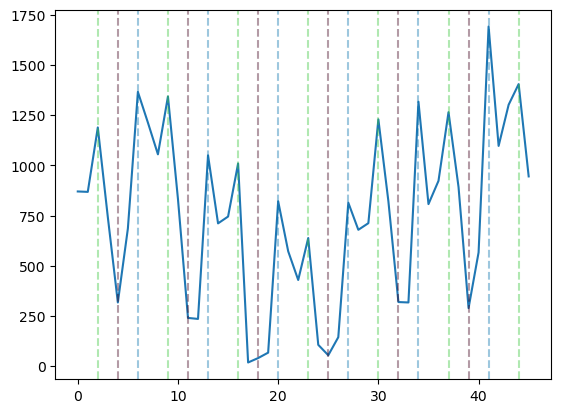

In [68]:
#observando a série temporal
plt.plot(dados['Vendas'])
for i in range(4,46,7):
    plt.axvline(i, color='#420420', linestyle='--',alpha=0.4)
for i in range(6,46,7):
    plt.axvline(i, color='#0a75ad', linestyle='--',alpha=0.4)
for i in range(2,46,7):
    plt.axvline(i, color='#3ac63d', linestyle='--',alpha=0.4)

- A série aparenta, visualmente, apresentar uma leve tendência. 

- Porém, apresenta uma clara sazonalidade semanal, dado que os picos e vales se distribuem 7 vezes, consecutivamente (mesmo número de semanas do período).

In [24]:
#ADH
X = dados['Vendas']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

#ADH log
result = adfuller(log(X))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.507607
p-value: 0.529745
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609
ADF Statistic: -1.552213
p-value: 0.507543
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


- Ambos os testes falharam em rejeitar H0. O que implica que a série não é estacionária.

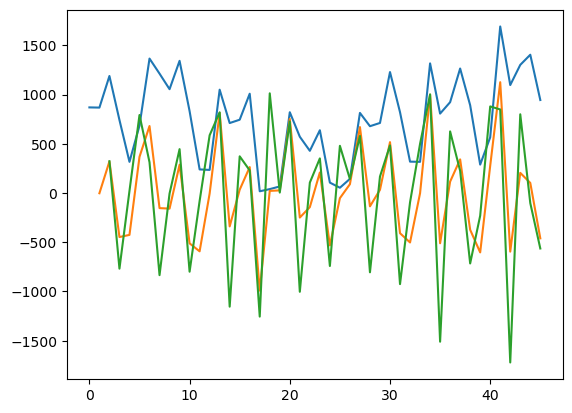

In [91]:
# tomando a diferença
diff = X.diff()
plt.plot(X)
plt.plot(diff)
plt.plot(diff.diff())

In [36]:
#ADH série diferenciada
## diferenciada 1 vez
result = adfuller(diff[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

## diferenciada 2 vezes
result = adfuller(diff.diff()[2:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.174417
p-value: 0.215661
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609
ADF Statistic: -6.249244
p-value: 0.000000
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


In [97]:
#separando dados para treino e teste
treino = list(diff[:42])
teste = list(diff[42:])

[nan, -2.0, 321.0, -447.0, -425.0, 368.0, 681.0, -153.0, -158.0, 288.0, -511.0, -592.0, -5.0, 815.0, -339.0, 34.0, 264.0, -991.0, 22.0, 27.0, 754.0, -249.0, -143.0, 209.0, -532.0, -52.0, 90.0, 670.0, -135.0, 33.0, 517.0, -408.0, -502.0, -2.0, 1000.0, -510.0, 116.0, 342.0, -373.0, -603.0, 277.0, 1126.0]


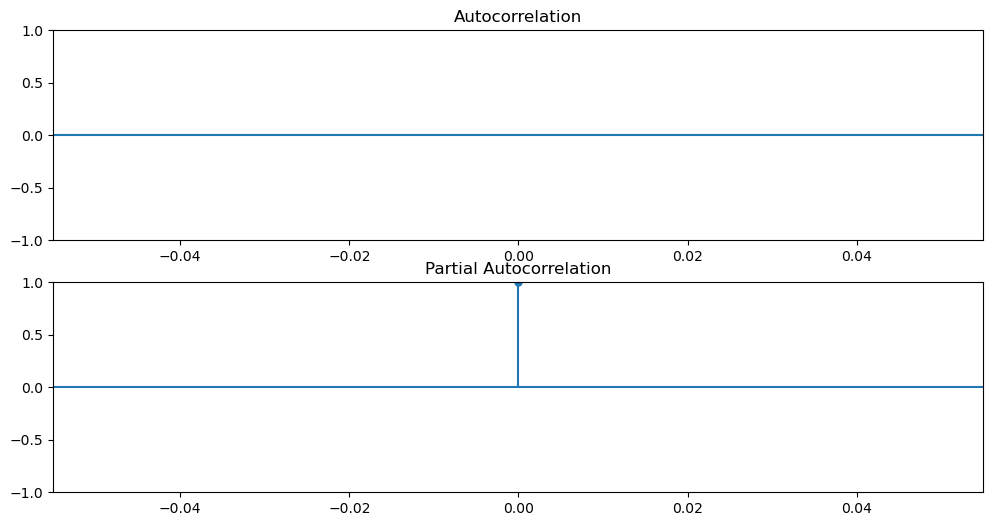

In [96]:
#ACF e PACF
fig,ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(treino, ax=ax[0], lags=20)
ax[1] = plot_pacf(treino, ax=ax[1], lags=20)

In [90]:
#construindo o modelo SARIMA(0,2,0)(1,0,1)7
ordem = (0,2,0)
sazonalidade = (1,0,1,7)
modelo = SARIMAX(treino,order=ordem,seasonla_oreder=sazonalidade)

In [84]:
#ajustando o modelo
modelo_ajustado = modelo.fit()
print(modelo_ajustado.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -317.882
Date:                Mon, 30 Jan 2023   AIC                            637.764
Time:                        22:50:34   BIC                            639.453
Sample:                             0   HQIC                           638.375
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.671e+05   1.41e+05      3.321      0.001    1.91e+05    7.43e+05
Ljung-Box (L1) (Q):                   5.08   Jarque-Bera (JB):                 3.18
Prob(Q):                              0.02   Pr

In [87]:
predicoes = modelo_ajustado.forecast(len(teste))
residuos = teste-predicoes

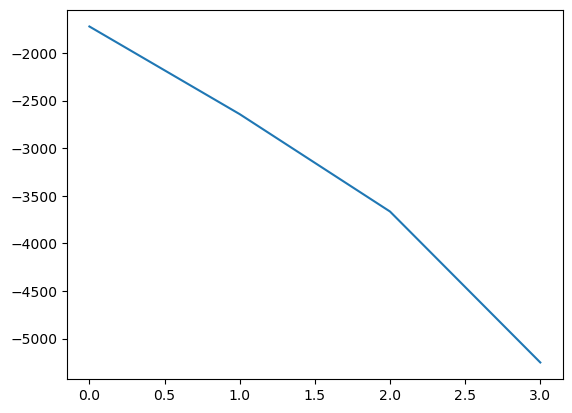

In [79]:
plt.plot(residuos)

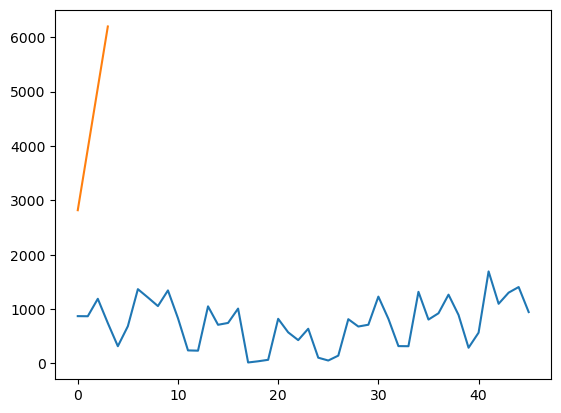

In [80]:
plt.plot(dados['Vendas'])
plt.plot(predicoes)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    
    
### <center>Obrigado pela leitura e a oportunidade de participar do desafio🙂</center>
### <center>Isso foi tudo 👋</center>